In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Addition 
- A + B

## Parameters Config
- Total data size: 80000
- Maximum data: 999
- Minimum data: 0
- Maximum result: 1998
- Minomum result: 0

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows): # ex: (C=43+7, num_rows=MAXLEN) or (C=50, num_rows=DIGITS + 1)
        x = np.zeros((num_rows, len(self.chars))) 
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [9]:
ctable.char_indices

{' ': 0,
 '+': 1,
 '0': 2,
 '1': 3,
 '2': 4,
 '3': 5,
 '4': 6,
 '5': 7,
 '6': 8,
 '7': 9,
 '8': 10,
 '9': 11}

## Data Generation

In [6]:
questions = []
expected = []
seen = set()      # 用來確保資料不會重複
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    # f 是一個產生 1-3 位數亂數的 function
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b) # 並沒有說小的數字放前面 大的數字放後面
    query = q + ' ' * (MAXLEN - len(q)) # 確保 input 長度一樣
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1] # [::-1] 會讓 query 相反過來，例如 "43+7   " 變成 "   7+34"，這個寫法我都不知道
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [7]:
print(questions[:5], expected[:5])

['368+847', '834+92 ', '69+3   ', '16+82  ', '10+156 '] ['1215', '926 ', '72  ', '98  ', '166 ']


## Processing

In [8]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) 
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN) # 取每一筆 sentence 的意思，每一筆 sentence 是用 7 * 12 的矩陣表示
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [9]:
indices = np.arange(len(y))
np.random.shuffle(indices) # 原來把資料弄亂還可以這樣寫
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    # 20000
train_y = y[:20000]
test_x = x[20000:]     # 60000
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Validation Data:
(2000, 7, 12)
(2000, 4, 12)
Testing Data:
(60000, 7, 12)
(60000, 4, 12)


## Build Model

In [50]:
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
# model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)),return_sequences=True))
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
# model.add(layers.Lambda(lambda x: x[:,-(DIGITS + 1):,:]))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.save('original_model.h5') 

## Training

In [ ]:
originList = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

## Testing

In [53]:
print("MSG : Prediction") 
loss, acc = model.evaluate(test_x,test_y)
print("Loss:",loss)
print("Accuracy:",acc)

MSG : Prediction
60000/60000 [==============================] - 4s 72us/step
Loss: 0.03193951640563707
Accuracy: 0.9897208333333334


In [24]:
model.metrics_names

['loss', 'acc']

# Subtraction 
- (A - B, A ≥ B)

## Parameters Config
- Total data size: 80000
- Maximum data: 999
- Minimum data: 0
- Maximum result: 999
- Minomum result: 0

In [57]:
chars_sub = '0123456789- '

In [58]:
ctable_sub = CharacterTable(chars_sub)

## Data Generation

In [63]:
questions_sub = []
expected_sub = []
seen_sub = set()      
print('Generating data...')
while len(questions_sub) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    a, b = max(a,b),min(a,b)
    key = tuple((a, b))
    if key in seen: 
        continue
    seen.add(key)
    q = '{}-{}'.format(a,b) # 大減小
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions_sub.append(query)
    expected_sub.append(ans)
print('Total addition questions:', len(questions_sub))

Generating data...
Total addition questions: 80000


In [66]:
print(questions_sub[5:10], expected_sub[5:10])

['700-599', '888-879', '501-300', '196-134', '813-698'] ['101 ', '9   ', '201 ', '62  ', '115 ']


## Process

In [67]:
print('Vectorization...')
x = np.zeros((len(questions_sub), MAXLEN, len(chars_sub)), dtype=np.bool) 
y = np.zeros((len(expected_sub), DIGITS + 1, len(chars_sub)), dtype=np.bool)
for i, sentence in enumerate(questions_sub):
    x[i] = ctable_sub.encode(sentence, MAXLEN) 
for i, sentence in enumerate(expected_sub):
    y[i] = ctable_sub.encode(sentence, DIGITS + 1)

Vectorization...


In [68]:
indices = np.arange(len(y))
np.random.shuffle(indices) 
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    
train_y = y[:20000]
test_x = x[20000:]     
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Validation Data:
(2000, 7, 12)
(2000, 4, 12)
Testing Data:
(60000, 7, 12)
(60000, 4, 12)


## Build model

In [70]:
print('Build model...')

model_sub = Sequential()
# model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)),return_sequences=True))
model_sub.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars_sub))))
model_sub.add(layers.RepeatVector(DIGITS + 1))
# model.add(layers.Lambda(lambda x: x[:,-(DIGITS + 1):,:]))
for _ in range(LAYERS):
    model_sub.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_sub.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_sub.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model_sub.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


## training

In [ ]:
originList_sub = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model_sub.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_sub.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_sub.predict_classes(rowx, verbose=0)
        q = ctable_sub.decode(rowx[0])
        correct = ctable_sub.decode(rowy[0])
        guess = ctable_sub.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

In [73]:
model_sub.save('original_model_sub.h5') 

## Testing

In [74]:
print("MSG : Prediction") 
loss, acc = model_sub.evaluate(test_x,test_y)
print("Loss:",loss)
print("Accuracy:",acc)

MSG : Prediction
60000/60000 [==============================] - 4s 74us/step
Loss: 0.02964235748577242
Accuracy: 0.9942666666666666


# Addition & Subtraction

In [76]:
chars_both = '0123456789+- '
    
ctable_both = CharacterTable(chars_both)

questions_both = []
expected_both = []
seen_both = set()      
print('Generating data...')
itor = 0
while len(questions_both) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen: 
        continue
    seen.add(key)
    if(itor % 2):
        a, b = max(a,b), min(a,b)
        q = '{}-{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q)) 
        ans = str(a - b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions_both.append(query)
        expected_both.append(ans)
    else:
        q = '{}+{}'.format(a, b) 
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1] 
        questions_both.append(query)
        expected_both.append(ans)
    itor += 1

Generating data...
Total addition questions: 485640


In [78]:
print(questions_both[:5],expected_both[:5])

['248+626', '962-309', '886+38 ', '878-543', '349+326'] ['874 ', '653 ', '924 ', '335 ', '675 ']


In [79]:
print('Vectorization...')
x = np.zeros((len(questions_both), MAXLEN, len(chars_both)), dtype=np.bool) 
y = np.zeros((len(expected_both), DIGITS + 1, len(chars_both)), dtype=np.bool)
for i, sentence in enumerate(questions_both):
    x[i] = ctable_both.encode(sentence, MAXLEN) 
for i, sentence in enumerate(expected_both):
    y[i] = ctable_both.encode(sentence, DIGITS + 1)

Vectorization...


In [80]:
indices = np.arange(len(y))
np.random.shuffle(indices) 
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]    
train_y = y[:20000]
test_x = x[20000:]     
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10  # split_at=18000
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 13)
(18000, 4, 13)
Validation Data:
(2000, 7, 13)
(2000, 4, 13)
Testing Data:
(60000, 7, 13)
(60000, 4, 13)


In [82]:
print('Build model...')

model_both = Sequential()
model_both.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars_both))))
model_both.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model_both.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_both.add(layers.TimeDistributed(layers.Dense(len(chars_both), activation='softmax')))
model_both.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model_both.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 128)               72704     
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 4, 128)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 4, 13)             1677      
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


In [ ]:
originList_both = []
for iteration in range(200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    result = model_both.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      validation_data=(x_val, y_val))
    originList_both.append(result.history['val_acc'][0])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_both.predict_classes(rowx, verbose=0)
        q = ctable_both.decode(rowx[0])
        correct = ctable_both.decode(rowy[0])
        guess = ctable_both.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

In [88]:
model_both.save('original_model_both.h5')

In [89]:
loss, acc = model_both.evaluate(test_x,test_y)

60000/60000 [==============================] - 5s 76us/step


In [90]:
print("Accuracy:",acc)

Accuracy: 0.9773958333333334


# Discussion
- 學習加法和減法的進度是很像的，但前提是減法一定是大減小，因此不需要考慮負的數字
- 同時學會加法和減法一定是比較困難的，因此需要比較多 epoch 才能達到學一個的準確率

In [91]:
import matplotlib.pyplot as plt

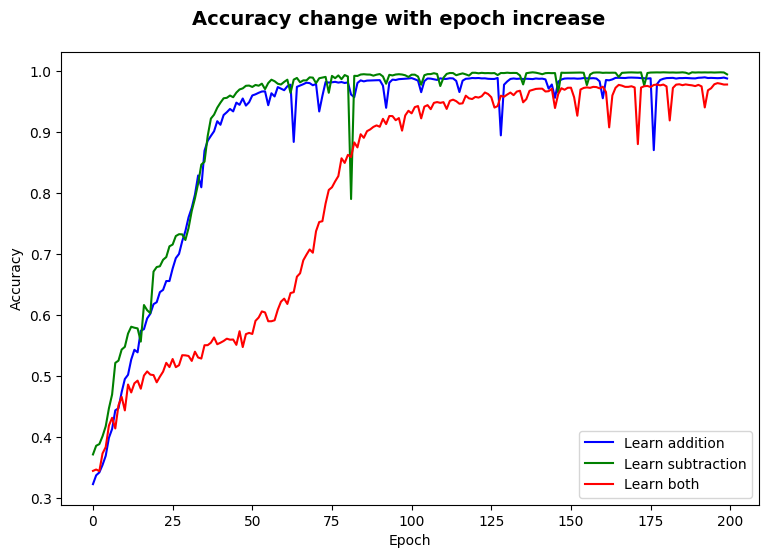

In [100]:
fig = plt.figure(figsize=(9,6),dpi=100)  
fig.suptitle('Accuracy change with epoch increase',y = 0.95, fontsize = 14, fontweight='bold')
ax = fig.add_subplot(1,1,1)
ax.plot(originList, color='b', label='Learn addition')
ax.plot(originList_sub, color='g', label='Learn subtraction')
ax.plot(originList_both, color='r', label='Learn both' )
ax.set_xlabel("Epoch")      
ax.set_ylabel("Accuracy")
ax.legend(loc=4)